In [1]:
import typing as tp
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [71]:
outputs_dir = Path('.').resolve().parent.parent.parent / "outputs"
# StanfordCars
# log_file_path = outputs_dir / "2022-10-03/17-14-25/image_attention.log"
# EuroSat
log_file_path = outputs_dir / "2022-10-26/21-29-26/image_attention.log"

In [72]:
def load_records(log_path: Path) -> tp.List[tp.Dict[str, tp.Any]]:
    with open(log_path) as f:
        return [json.loads(line.rstrip()) for line in f]

In [73]:
def load_log_records(*log_files_paths: Path, record_type: tp.Optional[str] = None) -> pd.DataFrame:
    files_records = []
    for log_file_path in log_files_paths:
        log_records = load_records(log_file_path)
        log_records = [record for record in log_records if record['message'] is None]
        if record_type is not None:
            log_records = [record for record in log_records if record.get('type') == record_type]
        files_records.extend(log_records)

    log_records_df = pd.json_normalize(files_records).drop(columns=['message', 'asctime'])
    return log_records_df

In [74]:
log_records_df = load_log_records(log_file_path, record_type='searcher_result')
log_records_df.head()

,name,levelname,alpha,acc1,acc5,type,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_value_strategy.scale,cache_weights_strategy._target_,cache_weights_strategy.beta
0,image_attention,INFO,0.0,37.506173,89.444444,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
1,image_attention,INFO,0.1,37.037037,88.950617,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
2,image_attention,INFO,0.5,35.679012,86.790123,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
3,image_attention,INFO,1.0,34.160494,83.246914,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
4,image_attention,INFO,2.0,31.864198,74.209877,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1


In [75]:
# adding hard_cache strategy
hard_cache_log_file_path = outputs_dir / "2022-10-26/04-47-34/image_attention.log"
hard_log_records_df = load_log_records(hard_cache_log_file_path, record_type='searcher_result')
hard_log_records_df = hard_log_records_df[hard_log_records_df['cache_strategy._target_'] == 'summer_clip.clip_searcher.cache_strategy.TopKStrategy']

hard_log_records_df['cache_value_strategy._target_'] = 'summer_clip.clip_searcher.cache_value_strategy.SoftmaxCacheStrategy'
hard_log_records_df['cache_value_strategy.scale'] = 'hard_cache'
hard_log_records_df = hard_log_records_df[log_records_df.columns]

log_records_df = pd.concat([log_records_df, hard_log_records_df], ignore_index=True)
log_records_df.head()

,name,levelname,alpha,acc1,acc5,type,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_value_strategy.scale,cache_weights_strategy._target_,cache_weights_strategy.beta
0,image_attention,INFO,0.0,37.506173,89.444444,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
1,image_attention,INFO,0.1,37.037037,88.950617,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
2,image_attention,INFO,0.5,35.679012,86.790123,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
3,image_attention,INFO,1.0,34.160494,83.246914,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
4,image_attention,INFO,2.0,31.864198,74.209877,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1


In [76]:
def add_zero_shots(log_records_df: pd.DataFrame, column_to_value: tp.Dict[str, tp.Any]) -> pd.DataFrame:
    zero_shot_df = log_records_df[log_records_df['alpha'] == 0].copy()
    for col_name, col_value in column_to_value.items():
        zero_shot_df[col_name] = col_value
    zero_shot_dfs = []

    for alpha in log_records_df['alpha'].unique():
        alpha_df = zero_shot_df.copy()
        alpha_df['alpha'] = alpha
        zero_shot_dfs.append(alpha_df)

    return pd.concat([log_records_df] + zero_shot_dfs, ignore_index=True)

In [77]:
log_records_df = add_zero_shots(log_records_df, {'cache_value_strategy.scale': 'zero_shot'})

log_records_df.head()

,name,levelname,alpha,acc1,acc5,type,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_value_strategy.scale,cache_weights_strategy._target_,cache_weights_strategy.beta
0,image_attention,INFO,0.0,37.506173,89.444444,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
1,image_attention,INFO,0.1,37.037037,88.950617,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
2,image_attention,INFO,0.5,35.679012,86.790123,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
3,image_attention,INFO,1.0,34.160494,83.246914,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1
4,image_attention,INFO,2.0,31.864198,74.209877,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1


In [78]:
visible_params = {
    'alpha', 'acc1', 'acc5', 'cache_strategy.topk',
    'cache_weights_strategy.beta', 'cache_value_strategy.scale'
}
static_columns = list(set(log_records_df.columns) - visible_params)
groups = list(log_records_df.groupby(static_columns))
print('# unique groups:', len(groups))

# unique groups: 1


In [79]:
static_values, part_df = groups[0]
static_items = dict(zip(static_columns, static_values))
static_items  # type: ignore

{'levelname': 'INFO',
 'cache_weights_strategy._target_': 'summer_clip.clip_searcher.cache_weights_strategy.TipAdapterWeightsStrategy',
 'cache_value_strategy._target_': 'summer_clip.clip_searcher.cache_value_strategy.SoftmaxCacheStrategy',
 'cache_strategy._target_': 'summer_clip.clip_searcher.cache_strategy.TopKStrategy',
 'name': 'image_attention',
 'type': 'searcher_result'}

In [80]:
def filter_records(part_df: pd.DataFrame, alpha: tp.Set[tp.Any], beta: tp.Set[tp.Any]) -> pd.DataFrame:
    alpha_mask = part_df['alpha'].isin(alpha)
    beta_mask = part_df['cache_weights_strategy.beta'].isin(beta)

    return part_df[alpha_mask & beta_mask]

In [81]:
alpha = {0.1, 2.0, 4.0}
beta = {1.5, 7.5, 11.5}

part_df = filter_records(part_df, alpha, beta)

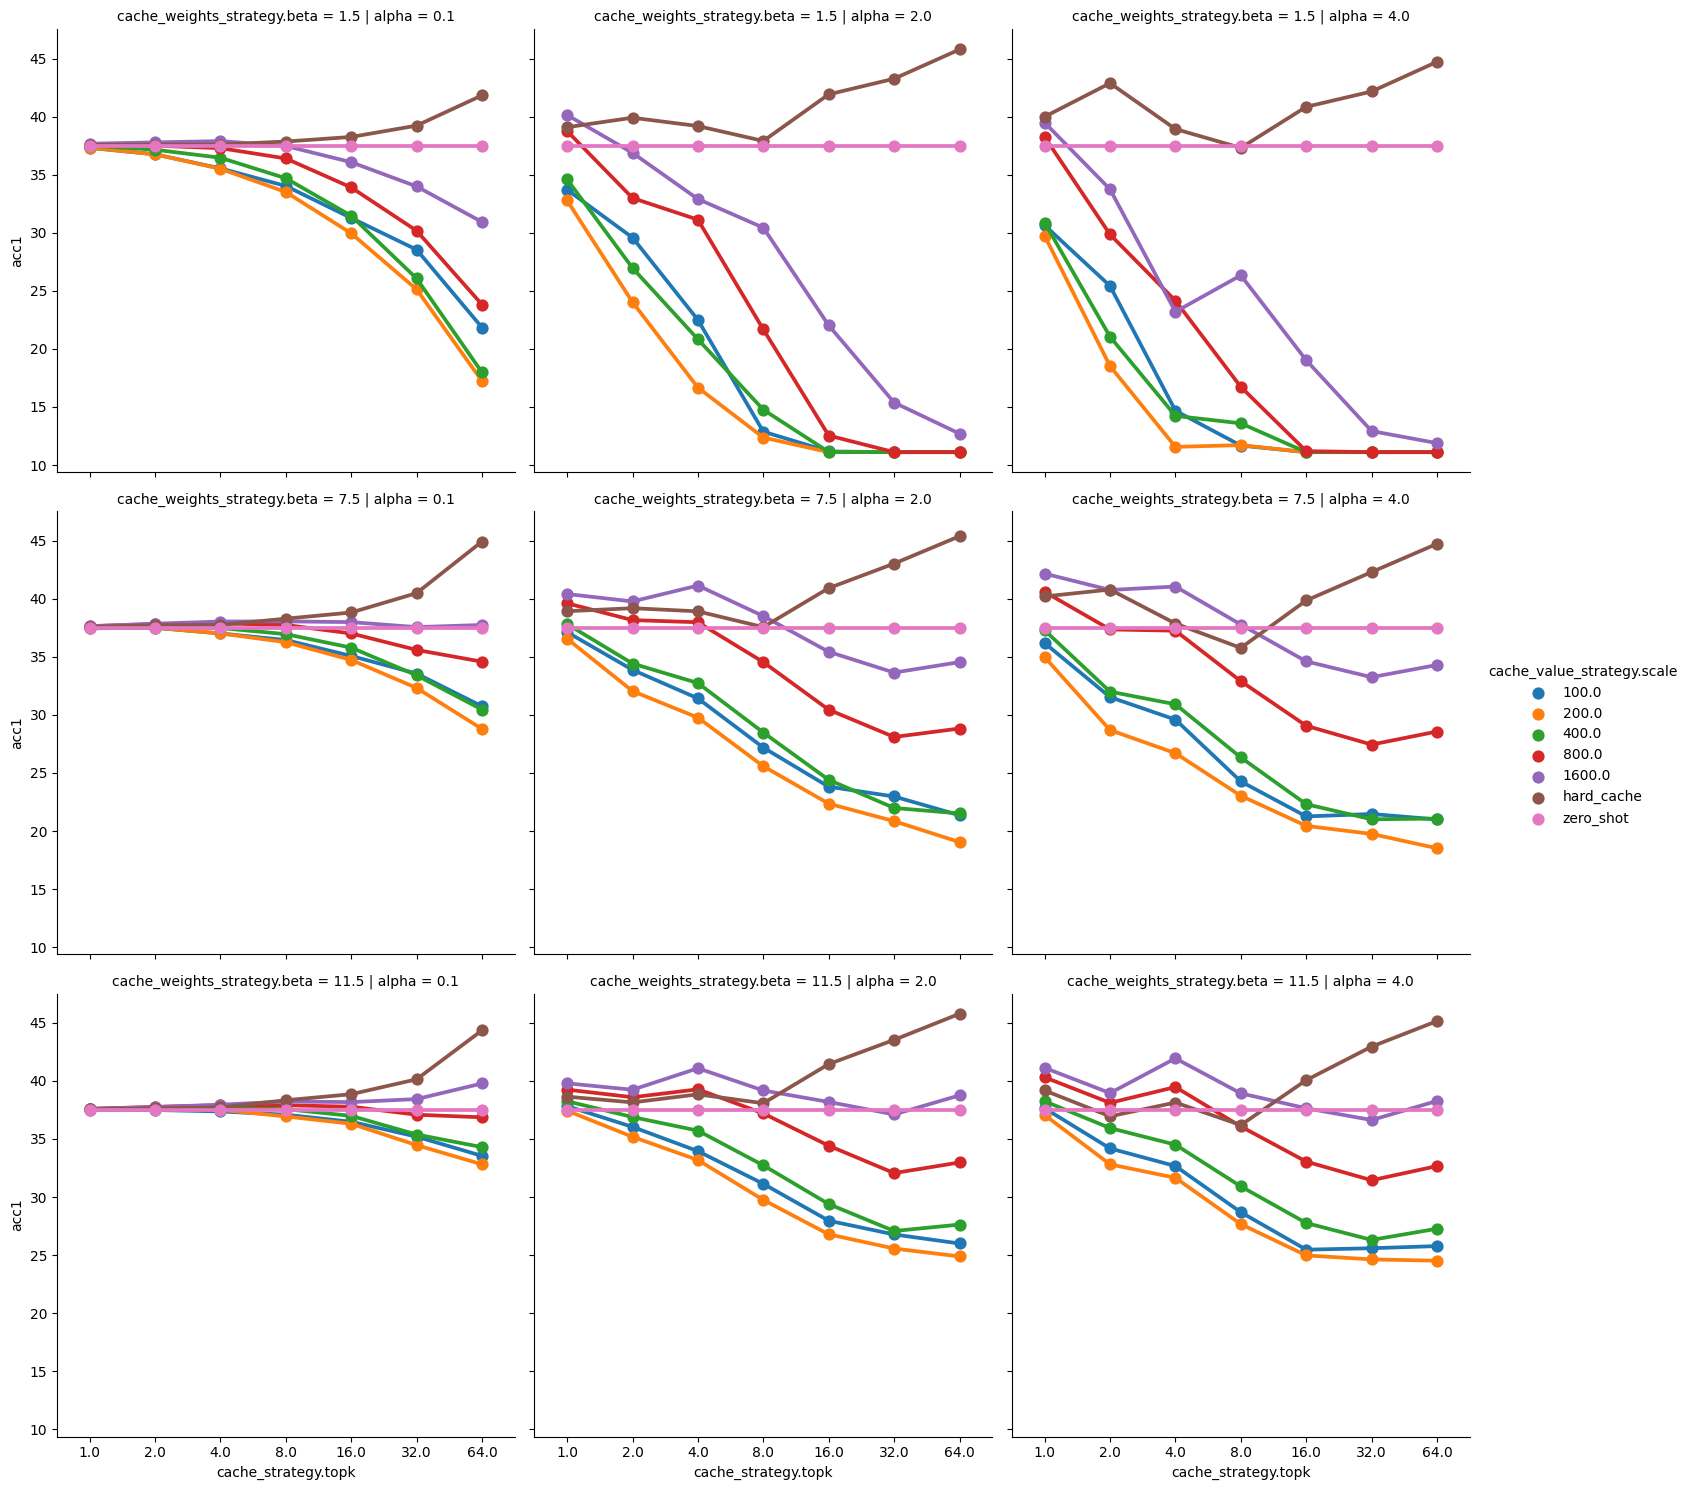

In [103]:
sns.catplot(
    data=part_df, x='cache_strategy.topk', y='acc1', col='alpha',
    row='cache_weights_strategy.beta', kind='point', hue='cache_value_strategy.scale'
)
plt.savefig('data/clip_search_22.pdf')

In [22]:
log_records_df.sort_values('acc1', ascending=False).head()

,name,levelname,alpha,acc1,acc5,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_value_strategy.scale,cache_weights_strategy._target_,cache_weights_strategy.beta
2182,image_attention,INFO,3.0,57.293869,89.752518,summer_clip.clip_searcher.cache_strategy.TopKS...,8,summer_clip.clip_searcher.cache_value_strategy...,hard_cache,summer_clip.clip_searcher.cache_weights_strate...,11.5
2167,image_attention,INFO,2.0,57.244124,89.541102,summer_clip.clip_searcher.cache_strategy.TopKS...,8,summer_clip.clip_searcher.cache_value_strategy...,hard_cache,summer_clip.clip_searcher.cache_weights_strate...,7.5
2174,image_attention,INFO,2.0,57.194379,89.740082,summer_clip.clip_searcher.cache_strategy.TopKS...,8,summer_clip.clip_searcher.cache_value_strategy...,hard_cache,summer_clip.clip_searcher.cache_weights_strate...,9.5
2175,image_attention,INFO,3.0,57.169506,89.454048,summer_clip.clip_searcher.cache_strategy.TopKS...,8,summer_clip.clip_searcher.cache_value_strategy...,hard_cache,summer_clip.clip_searcher.cache_weights_strate...,9.5
2139,image_attention,INFO,2.0,57.144634,88.297475,summer_clip.clip_searcher.cache_strategy.TopKS...,8,summer_clip.clip_searcher.cache_value_strategy...,hard_cache,summer_clip.clip_searcher.cache_weights_strate...,1.0


In [23]:
log_records_df[log_records_df['alpha'] == 0].head(1)

,name,levelname,alpha,acc1,acc5,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_value_strategy.scale,cache_weights_strategy._target_,cache_weights_strategy.beta
0,image_attention,INFO,0.0,55.62741,89.764955,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,100.0,summer_clip.clip_searcher.cache_weights_strate...,0.1


## Samples strategy comparison

In [33]:
# # StanfordCars: beta in log scale + w/o replace gold
# log_files_paths = [
#     outputs_dir / "2022-10-15/17-29-15/image_attention.log",
#     outputs_dir / "2022-10-15/17-30-35/image_attention.log",
#     outputs_dir / "2022-10-15/17-41-06/image_attention.log",
#     outputs_dir / "2022-10-15/17-42-36/image_attention.log",
#     outputs_dir / "2022-10-15/17-44-06/image_attention.log",
#     outputs_dir / "2022-10-15/17-46-36/image_attention.log",
# ]

In [138]:
log_files_map = {
    "eurosat": "2023-05-16/01-57-48/image_attention.log",
    "stanford_cars": "2023-05-16/01-50-38/image_attention.log",
    "imagenet": "2023-05-16/02-28-15/image_attention.log",
    "caltech101": "2023-05-16/03-24-24/image_attention.log"
}

In [139]:
CURRENT_DATASET = "caltech101"

log_files_paths = [outputs_dir / log_files_map[CURRENT_DATASET]]

In [140]:
# # # EuroSat: w/o replace gold
# log_files_paths = [
#     outputs_dir / "2023-05-16/01-57-48/image_attention.log"
# ]

In [141]:
# StanfordCars: w/o replace gold
# log_files_paths = [
#     outputs_dir / "2023-05-16/01-50-38/image_attention.log"
# ]

In [142]:
# # ImageNet: w/o replace gold
# log_files_paths = [
#     outputs_dir / "2023-05-09/06-30-15/image_attention.log"
# ]

In [143]:
# # StanfordCars: w/ replace gold
# log_files_paths = [
#     outputs_dir / "2022-09-21/22-17-29/image_attention.log",
#     outputs_dir / "2022-10-03/18-53-02/image_attention.log",
#     outputs_dir / "2022-09-21/23-30-23/image_attention.log",
#     outputs_dir / "2022-09-21/23-31-27/image_attention.log",
#     outputs_dir / "2022-09-21/23-09-05/image_attention.log",
#     outputs_dir / "2022-09-21/23-13-21/image_attention.log",
# ]

In [144]:
# EuroSat: w/ replace gold
# log_files_paths = [
#     outputs_dir / "2022-10-26/04-23-03/image_attention.log",
# ]

In [145]:
log_records_df = load_log_records(*log_files_paths, record_type='searcher_result')
# log_records_df = load_log_records(*log_files_paths)

log_records_df.head()

,name,levelname,alpha,acc1,acc5,type,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_weights_strategy._target_,cache_weights_strategy.beta,cache_strategy.scale,cache_strategy.cache_dataset._target_,cache_strategy.cache_dataset.dataset,cache_strategy.cache_dataset.split,cache_strategy.cache_dataset.root_path,cache_strategy.cache_dataset.shots,cache_strategy.cache_dataset.is_train,cache_strategy.cache_dataset.use_custom_preprocess,cache_strategy.cache_dataset.load_images
0,image_attention,INFO,0.0,83.975659,98.215010,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,image_attention,INFO,0.1,83.935091,98.215010,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,image_attention,INFO,0.5,83.894523,98.133874,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,image_attention,INFO,1.0,83.935091,98.133874,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,image_attention,INFO,2.0,83.975659,98.133874,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
def fill_topk(log_records_df: pd.DataFrame) -> pd.DataFrame:
    topk_mask = log_records_df['cache_strategy.topk'].isna()
    full_topk_df = log_records_df[~topk_mask]
    empty_topk_df = log_records_df[topk_mask]

    topk_dfs = []
    for topk in full_topk_df['cache_strategy.topk'].unique():
        topk_df = empty_topk_df.copy()
        topk_df['cache_strategy.topk'] = topk
        topk_dfs.append(topk_df)

    return pd.concat([full_topk_df] + topk_dfs, ignore_index=True)

In [147]:
log_records_df = fill_topk(log_records_df)

log_records_df.head()

,name,levelname,alpha,acc1,acc5,type,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_weights_strategy._target_,cache_weights_strategy.beta,cache_strategy.scale,cache_strategy.cache_dataset._target_,cache_strategy.cache_dataset.dataset,cache_strategy.cache_dataset.split,cache_strategy.cache_dataset.root_path,cache_strategy.cache_dataset.shots,cache_strategy.cache_dataset.is_train,cache_strategy.cache_dataset.use_custom_preprocess,cache_strategy.cache_dataset.load_images
0,image_attention,INFO,0.0,83.975659,98.215010,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,image_attention,INFO,0.1,83.935091,98.215010,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,image_attention,INFO,0.5,83.894523,98.133874,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,image_attention,INFO,1.0,83.935091,98.133874,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,image_attention,INFO,2.0,83.975659,98.133874,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
columns_to_drop = [
    column for column in log_records_df.columns
    if column.startswith('cache_strategy.cache_dataset') \
    or column.startswith('cache_strategy.scale')
]
log_records_df = log_records_df.drop(columns=columns_to_drop)
log_records_df.head()

,name,levelname,alpha,acc1,acc5,type,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_weights_strategy._target_,cache_weights_strategy.beta
0,image_attention,INFO,0.0,83.975659,98.215010,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
1,image_attention,INFO,0.1,83.935091,98.215010,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
2,image_attention,INFO,0.5,83.894523,98.133874,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
3,image_attention,INFO,1.0,83.935091,98.133874,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
4,image_attention,INFO,2.0,83.975659,98.133874,searcher_result,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1


In [149]:
def shrink_strategies(log_records_df: pd.DataFrame) -> pd.DataFrame:
    def shrink_strategy_name(strategy_name: str) -> str:
        prefix = 'summer_clip.clip_searcher.cache_strategy.'
        if not strategy_name.startswith(prefix):
            return strategy_name
        return strategy_name[len(prefix):]

    log_records_df['cache_strategy._target_'] = (
        log_records_df['cache_strategy._target_'].apply(shrink_strategy_name)
    )
    return log_records_df

In [150]:
log_records_df = add_zero_shots(log_records_df, {'cache_strategy._target_': 'summer_clip.clip_searcher.cache_strategy.ZeroShotStrategy'})
log_records_df = shrink_strategies(log_records_df)

log_records_df.head()

,name,levelname,alpha,acc1,acc5,type,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_weights_strategy._target_,cache_weights_strategy.beta
0,image_attention,INFO,0.0,83.975659,98.215010,searcher_result,TopKStrategy,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
1,image_attention,INFO,0.1,83.935091,98.215010,searcher_result,TopKStrategy,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
2,image_attention,INFO,0.5,83.894523,98.133874,searcher_result,TopKStrategy,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
3,image_attention,INFO,1.0,83.935091,98.133874,searcher_result,TopKStrategy,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
4,image_attention,INFO,2.0,83.975659,98.133874,searcher_result,TopKStrategy,1.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1


In [151]:
visible_params = {
    'alpha', 'acc1', 'acc5', 'cache_strategy.topk',
    'cache_weights_strategy.beta', 'cache_value_strategy.scale',
    'cache_strategy._target_',
}
static_columns = list(set(log_records_df.columns) - visible_params)
groups = list(log_records_df.groupby(static_columns, dropna=False))
print('# unique groups:', len(groups))

# unique groups: 1


In [152]:
static_values, part_df = groups[0]
static_items = dict(zip(static_columns, static_values))
static_items  # type: ignore

{'levelname': 'INFO',
 'cache_weights_strategy._target_': 'summer_clip.clip_searcher.cache_weights_strategy.TipAdapterWeightsStrategy',
 'cache_value_strategy._target_': 'summer_clip.clip_searcher.cache_value_strategy.HardCacheStrategy',
 'name': 'image_attention',
 'type': 'searcher_result'}

In [153]:
part_df = filter_records(part_df, alpha, beta)

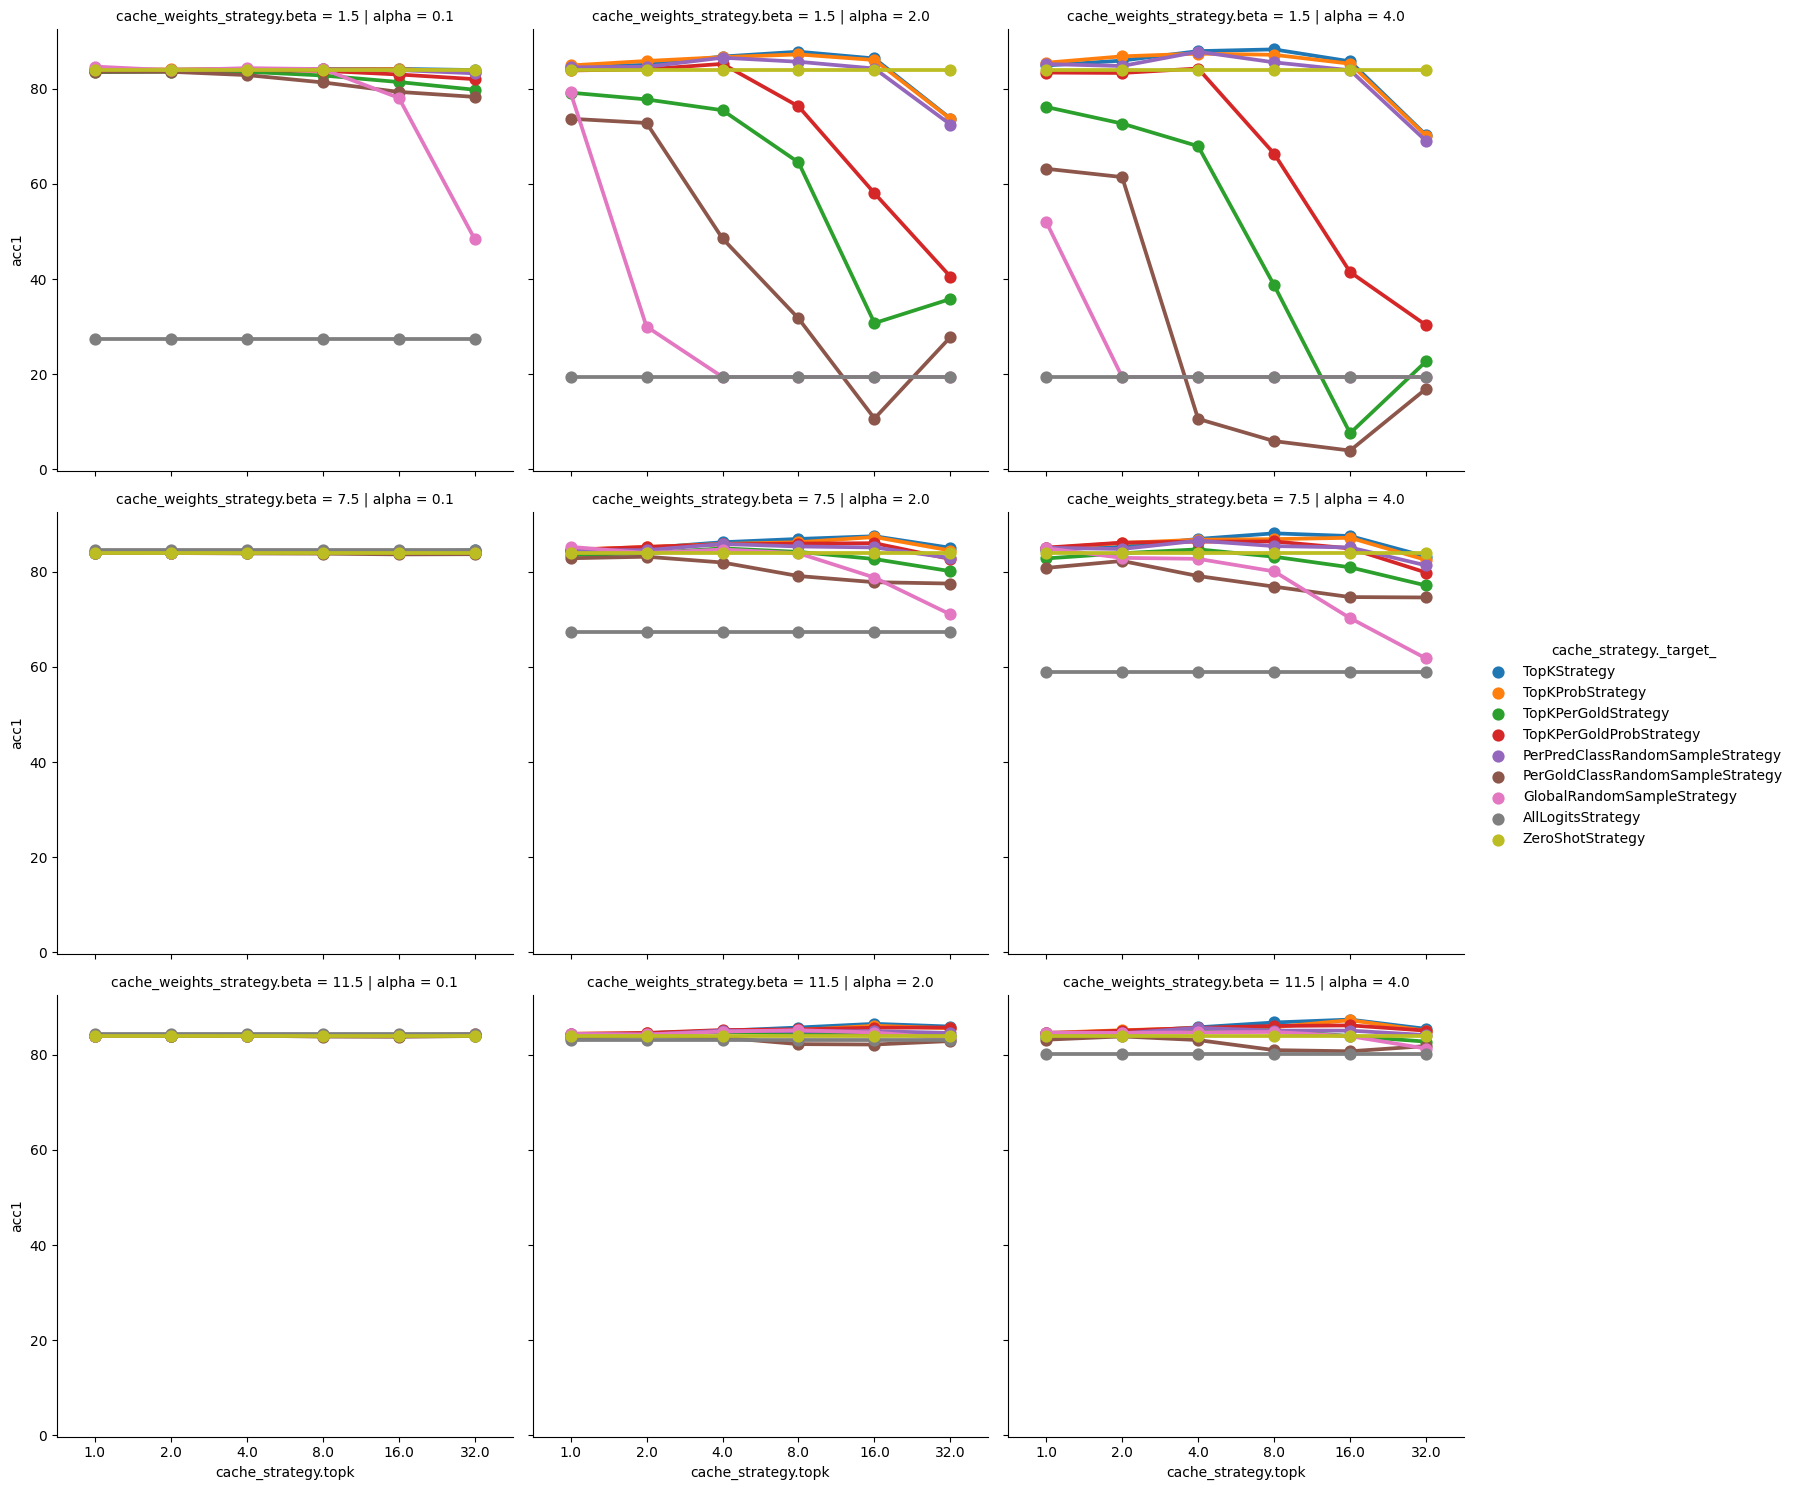

In [154]:
sns.catplot(
    data=part_df, x='cache_strategy.topk', y='acc1', col='alpha',
    row='cache_weights_strategy.beta', kind='point', hue='cache_strategy._target_'
)
plt.savefig('data/clip_search_44.pdf')

In [155]:
log_records_df.sort_values('acc1', ascending=False).head()

,name,levelname,alpha,acc1,acc5,type,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_weights_strategy._target_,cache_weights_strategy.beta
202,image_attention,INFO,4.0,88.438134,98.336714,searcher_result,TopKStrategy,8.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,5.5
195,image_attention,INFO,4.0,88.356998,98.133874,searcher_result,TopKStrategy,8.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,3.5
188,image_attention,INFO,4.0,88.235294,97.687627,searcher_result,TopKStrategy,8.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,1.5
194,image_attention,INFO,3.0,88.154158,98.255578,searcher_result,TopKStrategy,8.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,3.5
201,image_attention,INFO,3.0,88.113590,98.377282,searcher_result,TopKStrategy,8.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,5.5


### Cache quality

In [156]:
log_records_df = load_log_records(*log_files_paths, record_type='cache_info')
log_records_df = fill_topk(log_records_df)
log_records_df = shrink_strategies(log_records_df)

log_records_df.head()

,name,levelname,cache_size,acc1,acc5,type,cache_strategy._target_,cache_strategy.topk,cache_strategy.scale,cache_strategy.cache_dataset._target_,cache_strategy.cache_dataset.dataset,cache_strategy.cache_dataset.split,cache_strategy.cache_dataset.root_path,cache_strategy.cache_dataset.shots,cache_strategy.cache_dataset.is_train,cache_strategy.cache_dataset.use_custom_preprocess,cache_strategy.cache_dataset.load_images
0,image_attention,INFO,99,94.949495,100.000000,cache_info,TopKStrategy,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,image_attention,INFO,198,93.939394,100.000000,cache_info,TopKStrategy,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,image_attention,INFO,396,93.939394,100.000000,cache_info,TopKStrategy,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,image_attention,INFO,784,93.494898,99.872449,cache_info,TopKStrategy,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,image_attention,INFO,1516,90.105541,99.340369,cache_info,TopKStrategy,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


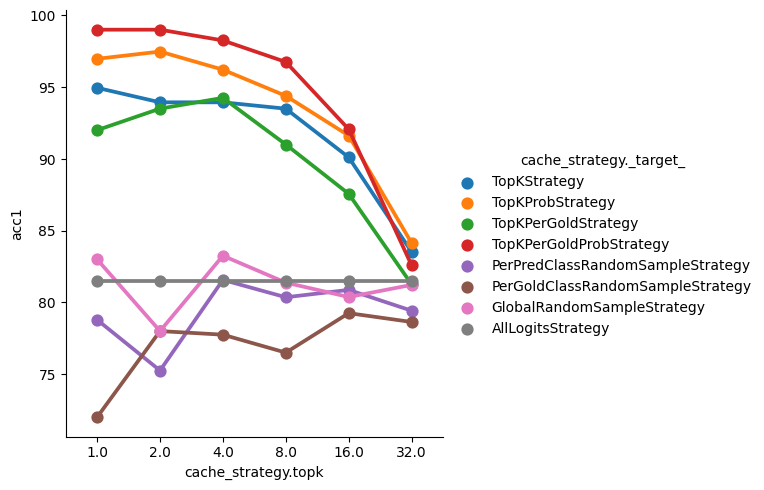

In [157]:
sns.catplot(
    data=log_records_df, kind='point',
    x='cache_strategy.topk', y='acc1', hue='cache_strategy._target_'
)
plt.savefig('data/cache_info_14.pdf')